# JPEG 静图像压缩实验

## JPEG 编码程序

Original # of bytes: 65536

Demo JPEG:
# of bits:  44487
# of bytes: 5561

Our JPEG:
# of bits:  44460
# of bytes: 5558

Difference between demo and our JPEG:


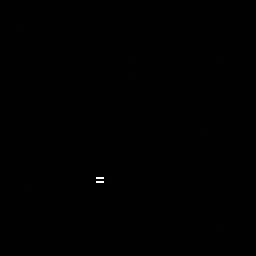

MAE:   0.140533447265625
RMSE:  0.19032699554812238


In [1]:
from PIL import Image
from IPython.display import display

import itertools
import subprocess
import numpy as np
import pandas as pd
from scipy import fftpack
import matplotlib.pyplot as plt

with open('demo/lady.dat', 'rb') as f:
    data = f.read()
in_length = len(data)
in_image = Image.fromarray(np.frombuffer(data, dtype=np.uint8).reshape((256, 256)))


def evaluate_ratio(n_bytes, silent=False):
    ratio = in_length / n_bytes
    if not silent:
        print(f'Ratio:      {ratio:.4f}')
    return ratio


def evaluate_loss(image, silent=False):
    diff = np.abs(np.array(in_image) - np.array(image))
    mae = np.mean(diff)
    rmse = np.sqrt(np.mean(diff**2))
    psnr = 10 * np.log10(255**2 / np.mean(diff**2))
    if not silent:
        print(f'MAE:        {mae:.4f}')
        print(f'RMSE:       {rmse:.4f}')
        print(f'PSNR:       {psnr:.4f} dB')
    return mae, rmse, psnr


def demo_jpeg():
    subprocess.run(['./jpg_r'], cwd='demo')
    with open('demo/jpg_code.txt', 'r') as f:
        n_bits = len(f.read())
        print(f'# of bits:  {n_bits}')
    with open('demo/lady_pre.dat', 'rb') as f:
        n_bytes = len(f.read())
        print(f'# of bytes: {n_bytes}')
    subprocess.run(['./genjpg', 'lady_pre.dat', 'lady.jpg'], cwd='demo')
    return Image.open('demo/lady.jpg'), n_bits, n_bytes


def my_jpeg(
    *,
    g_scale=8,
    chroma=False,
    offset_domain='spatial',
    decode=False,
    silent=False,
    id=None,
):
    # Load binary data
    with open('demo/lady.dat', 'rb') as f:
        data = f.read()
    data = np.frombuffer(data, dtype=np.uint8)
    data = data.reshape((256, 256))
    data = data.astype(np.float64)

    # 8x8 Splitting
    iter = itertools.product(range(0, 256, 8), range(0, 256, 8))
    blocks = [data[y : y + 8, x : x + 8] for y, x in iter]
    if id is not None:
        print('Initial block:')
        print(blocks[id])
        print()

    # DCT
    def dct(block):
        if offset_domain == 'spatial':
            block = block - 128
        block = fftpack.dct(fftpack.dct(block.T, norm='ortho').T, norm='ortho')
        return block

    blocks = [dct(block) for block in blocks]
    if id is not None:
        print('After DCT:')
        print(np.array_str(blocks[id], precision=1, suppress_small=True))
        print()

    # Quantization
    if chroma:
        from tables import chroma_quant_table as quant_table
    else:
        from tables import quant_table
    q_mat = np.array(quant_table, dtype=np.float64)
    q_mat = q_mat * g_scale / 8
    q_mat[0, 0] = quant_table[0][0]

    def quant(block):
        block = block / q_mat
        block = np.sign(block) * (np.abs(block) + 0.5)
        return block.astype(np.int16)

    blocks = [quant(block) for block in blocks]
    if id is not None:
        print('After quantization:')
        print(blocks[id])
        print()
    if decode:
        quant_blocks = blocks

    # Zigzag Scanning
    from tables import zigzag_x, zigzag_y

    dc_blocks = np.array([block[0, 0] for block in blocks])
    ac_blocks = [block[zigzag_y, zigzag_x] for block in blocks]
    if id is not None:
        print('DC & AC coefficients:')
        print(dc_blocks[id], ac_blocks[id])
        print()

    # DC Differential Coding
    if offset_domain == 'spectral':
        dc_blocks = dc_blocks - 64
    dc_blocks = np.diff(dc_blocks, prepend=0)
    if id is not None:
        print('DC after differential coding:')
        print(dc_blocks[id])
        print()

    # DC Huffman Coding
    from tables import dc_table

    def dc_huffman(dc):
        size = np.ceil(np.log2(np.abs(dc) + 1)).astype(np.int8)
        size_code = dc_table[size]
        amp = (dc < 0) * (2**size - 1) + dc
        amp_code = bin(amp)[2:].zfill(size)[:size]
        return size_code + amp_code

    dc_blocks = [dc_huffman(block) for block in dc_blocks]
    if id is not None:
        print('DC after Huffman coding:')
        print(dc_blocks[id])
        print()

    # AC Run-Length Coding
    def rlc(ac):
        indices = np.nonzero(ac)[0]
        values = ac[indices]
        runs = np.diff(indices, prepend=-1) - 1
        return runs, values

    ac_blocks = [rlc(block) for block in ac_blocks]
    if id is not None:
        print('AC after run-length coding:')
        print(ac_blocks[id][0])
        print(ac_blocks[id][1])
        print()

    # AC Huffman Coding
    from tables import ac_table

    def ac_huffman(ac):
        runs, values = ac

        def enc_pair(run, value):
            size = np.ceil(np.log2(np.abs(value) + 1)).astype(np.int8)
            size_code = run // 16 * ac_table[(15, 0)] + ac_table[(run % 16, size)]
            amp_code = bin((value < 0) * (2**size - 1) + value)[2:].zfill(size)
            return size_code + amp_code

        ac = ''.join(enc_pair(run, value) for run, value in zip(runs, values))
        ac += ac_table[(0, 0)]
        return ac

    ac_blocks = [ac_huffman(block) for block in ac_blocks]
    if id is not None:
        print('AC after run-length coding:')
        print(ac_blocks[id])
        print()

    # Byte Stuffing
    blocks = [dc + ac for dc, ac in zip(dc_blocks, ac_blocks)]
    data = ''.join(blocks)
    indices = [i for i in range(0, len(data), 8) if data[i : i + 8] == '11111111']
    for i in reversed(indices):
        data = data[: i + 8] + '00000000' + data[i + 8 :]

    # Save encoded data
    if not decode:
        with open('demo/my_code.txt', 'w') as f:
            f.write(data)
    n_bits = len(data)
    if not silent:
        print(f'# of bits:  {n_bits}')
    if len(data) % 8 != 0:
        data += '0' * (8 - len(data) % 8)
    data = bytes(int(data[i : i + 8], 2) for i in range(0, len(data), 8))
    n_bytes = len(data)
    if not decode:
        with open('demo/my_lady_pre.dat', 'wb') as f:
            f.write(data)
    if not silent:
        print(f'# of bytes: {n_bytes}')

    if decode:
        # Inverse Quantization & IDCT
        def inv_quant_dct(block):
            block = block * q_mat
            block = fftpack.idct(fftpack.idct(block.T, norm='ortho').T, norm='ortho')
            if offset_domain == 'spatial':
                block = np.round(block + 128)
            return np.clip(block, 0, 255).astype(np.uint8)

        blocks = [inv_quant_dct(block) for block in quant_blocks]
        data = np.zeros((256, 256), dtype=np.uint8)
        iter = itertools.product(range(0, 256, 8), range(0, 256, 8))
        for block, (y, x) in zip(blocks, iter):
            data[y : y + 8, x : x + 8] = block
        decoded_image = Image.fromarray(data)
        return decoded_image, n_bits, n_bytes
    else:
        assert g_scale == 8 and not chroma
        # Generate JPEG file
        subprocess.run(['./genjpg', 'my_lady_pre.dat', 'my_lady.jpg'], cwd='demo')
        return Image.open('demo/my_lady.jpg'), n_bits, n_bytes


print(f'Original # of bytes: {in_length}')
print()
print('Demo JPEG:')
demo_image, _, demo_length = demo_jpeg()
print()
print('Our JPEG:')
my_image, _, my_length = my_jpeg()
print()
print('Difference between demo and our JPEG:')
diff = np.abs(np.array(demo_image) - np.array(my_image))
display(Image.fromarray(diff))
print('MAE:  ', np.mean(diff))
print('RMSE: ', np.sqrt(np.mean(diff**2)))

## 思考题

1. 计算图像的压缩比, 并比较原图像的效果.


Demo program:
Ratio:      11.7849
MAE:        106.3914
RMSE:       4.6069
PSNR:       34.8627 dB

Our program:
Ratio:      11.7913
MAE:        105.9499
RMSE:       4.6065
PSNR:       34.8635 dB

Original vs. Demo vs. Ours


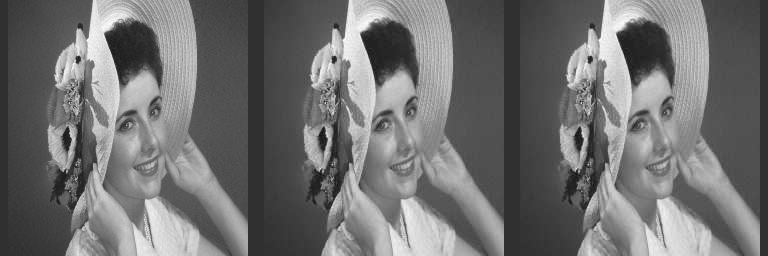

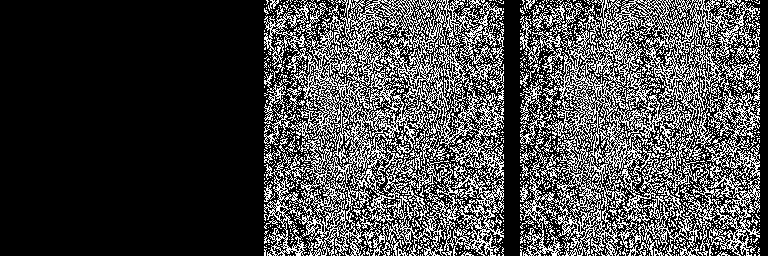

In [2]:
print()
print('Demo program:')
evaluate_ratio(demo_length)
evaluate_loss(demo_image)
print()
print('Our program:')
evaluate_ratio(my_length)
evaluate_loss(my_image)
print()
print('Original vs. Demo vs. Ours')
stacked_data = np.hstack((in_image, demo_image, my_image))
display(Image.fromarray(stacked_data))
stacked_diff = np.abs(np.tile(np.array(in_image), 3) - stacked_data)
display(Image.fromarray(stacked_diff))

2. 改变 `g_scale` 和量化矩阵中的元素, 比较压缩比和恢复图像的效果.

In [3]:
def run_experiment(g_scale, chroma):
    image, n_bits, n_bytes = my_jpeg(
        g_scale=g_scale, chroma=chroma, decode=True, silent=True
    )
    ratio = evaluate_ratio(n_bytes, silent=True)
    mae, rmse, psnr = evaluate_loss(image, silent=True)
    return image, ratio, mae, rmse, psnr


g_scales = range(1, 31)
chromas = [False, True]

results = []
for g_scale, chroma in itertools.product(g_scales, chromas):
    image, ratio, mae, rmse, psnr = run_experiment(g_scale, chroma)
    results.append((g_scale, chroma, ratio, mae, rmse, psnr, image))
results = pd.DataFrame(
    results, columns=['g_scale', 'chroma', 'ratio', 'mae', 'rmse', 'psnr', 'image']
)
results.set_index(['chroma', 'g_scale'], inplace=True)
results.sort_index(inplace=True)
results

ratio         mae      rmse       psnr   
chroma g_scale                                               
False  1         3.185070   96.055298  2.109700  41.646388  \
       2         4.892207  102.437851  3.011349  38.555582   
       3         6.280402  103.694077  3.550167  37.125829   
       4         7.553711  104.248093  3.903247  36.302283   
       5         8.740464  105.290222  4.135732  35.799756   
       6         9.852075  105.933197  4.337669  35.385676   
       7        10.909938  105.675400  4.482491  35.100415   
       8        11.791292  105.926773  4.607294  34.861885   
       9        12.639537  106.641068  4.748733  34.599249   
       10       13.504224  106.985336  4.832565  34.447250   
       11       14.302924  107.170532  4.945883  34.245926   
       12       15.138831  107.081024  4.996514  34.157462   
       13       15.945499  107.475708  5.060664  34.046653   
       14       16.675827  107.367249  5.121542  33.942789   
       15       17.411265  107.975677  5.199737  33.811177   
       16       18.093871  107.951920  5.233382  33.755154   
       17       18.767468  107.916351  5.274754  33.686760   
       18       19.377883  108.043518  5.310110  33.628734   
       19       19.913704  108.091354  5.365417  33.538733   
       20       20.480000  108.262543  5.393514  33.493367   
       21       20.984950  107.954102  5.437553  33.422733   
       22       21.564988  107.855469  5.443196  33.413723   
       23       22.036315  107.904678  5.492942  33.334704   
       24       22.405470  108.261780  5.542326  33.256962   
       25       22.914685  108.626526  5.563701  33.223527   
       26       23.455977  108.480835  5.598936  33.168694   
       27       23.909522  108.726700  5.616529  33.141444   
       28       24.353772  108.816895  5.650010  33.089820   
       29       24.843063  108.918442  5.679111  33.045196   
       30       25.196463  108.818954  5.706170  33.003909   
True   1         4.647943  101.304337  2.760188  39.312031   
       2         7.885453  105.093323  3.954264  36.189491   
       3        10.424050  105.492157  4.533038  35.003017   
       4        12.622496  106.157181  4.831652  34.448890   
       5        14.589492  106.969116  5.056387  34.053998   
       6        16.367632  106.674652  5.210642  33.792979   
       7        18.118883  107.536179  5.315605  33.619749   
       8        19.811366  107.460770  5.410825  33.465534   
       9        21.257217  107.641846  5.475799  33.361854   
       10       22.544204  107.319443  5.534200  33.269707   
       11       23.744928  107.831482  5.571142  33.211918   
       12       24.665412  107.682159  5.614027  33.145313   
       13       25.570035  107.842346  5.642105  33.101981   
       14       26.489895  107.309937  5.685471  33.035474   
       15       27.170813  107.891006  5.704049  33.007138   
       16       27.935209  108.171524  5.765351  32.914288   
       17       28.731258  108.013443  5.778566  32.894401   
       18       29.362007  108.335541  5.819707  32.832781   
       19       30.034830  108.297394  5.842037  32.799518   
       20       30.595705  108.123917  5.876336  32.748671   
       21       31.148289  108.274933  5.901471  32.711598   
       22       31.629344  108.298996  5.937548  32.658662   
       23       32.204423  108.317184  5.948224  32.643058   
       24       32.556384  108.885193  5.980661  32.595819   
       25       33.098990  109.186310  6.018174  32.541509   
       26       33.556580  108.932953  6.059172  32.482538   
       27       33.956477  108.940872  6.064296  32.475196   
       28       34.330016  109.142853  6.095678  32.430364   
       29       34.822529  108.940598  6.098560  32.426258   
       30       35.253362  109.232620  6.119052  32.397121   

                                                            image  
chroma g_scale                                                     
False  1        <PIL.Image.Image image 

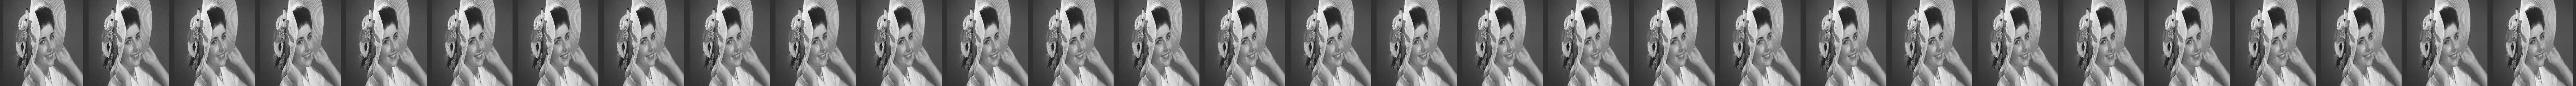

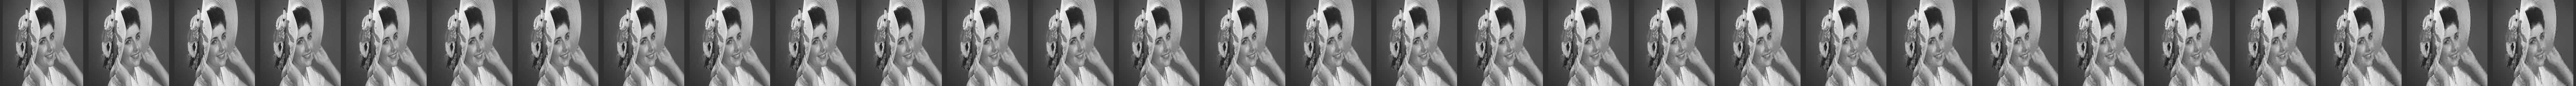

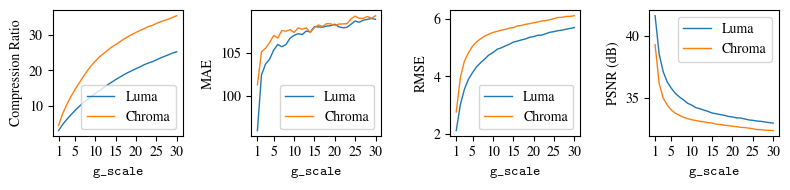

In [6]:
results['image'].unstack().apply(
    lambda x: display(Image.fromarray(np.hstack(x))), axis=1
)
plt.figure(figsize=(8, 2))
plt.subplot(141)
plt.plot(results['ratio'][False], label='Luma')
plt.plot(results['ratio'][True], label='Chroma')
plt.xlabel(r'$\mathtt{g\_scale}$')
plt.ylabel('Compression Ratio')
plt.legend()
plt.xticks([1, 5, 10, 15, 20, 25, 30])
plt.subplot(142)
plt.plot(results['mae'][False], label='Luma')
plt.plot(results['mae'][True], label='Chroma')
plt.xlabel(r'$\mathtt{g\_scale}$')
plt.ylabel('MAE')
plt.legend()
plt.xticks([1, 5, 10, 15, 20, 25, 30])
plt.subplot(143)
plt.plot(results['rmse'][False], label='Luma')
plt.plot(results['rmse'][True], label='Chroma')
plt.xlabel(r'$\mathtt{g\_scale}$')
plt.ylabel('RMSE')
plt.legend()
plt.xticks([1, 5, 10, 15, 20, 25, 30])
plt.subplot(144)
plt.plot(results['psnr'][False], label='Luma')
plt.plot(results['psnr'][True], label='Chroma')
plt.xlabel(r'$\mathtt{g\_scale}$')
plt.ylabel('PSNR (dB)')
plt.xticks([1, 5, 10, 15, 20, 25, 30])
plt.legend()
plt.tight_layout()
plt.show()